# Holography Simulator

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import unwrap_phase

from libertem.utils.generate import hologram_frame
from libertem.io.dataset.memory import MemoryDataSet
from libertem.udf.holography import HoloReconstructUDF
from libertem.api import Context

import hyperspy.api as hs

In [28]:
# Setup context
ctx = Context()

c:\Users\cttew\Desktop\code\holo\venv\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62026 instead
  warnings.warn(


Generate amplitude and phase images.

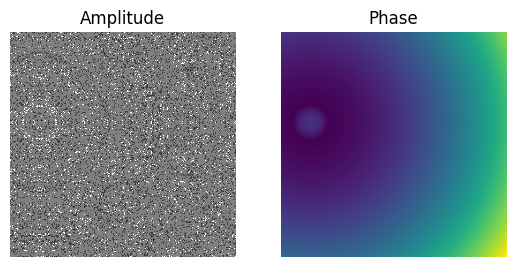

In [29]:
# Define grid
sx, sy = (256, 256)
mx, my = np.meshgrid(np.arange(sx), np.arange(sy))
# Define sphere region
sphere = (mx - 33.)**2 + (my - 103.)**2 < 20.**2
# Calculate long-range contribution to the phase
phase = ((mx - 33.)**2 + (my - 103.)**2) / sx / 40.
# Add mean inner potential contribution to the phase
phase[sphere] += (-((mx[sphere] - 33.)**2 \
+ (my[sphere] - 103.)**2) / sx / 3 + 0.5) * 2.
# Calculate amplitude of the phase
amp = np.ones_like(phase)
amp[sphere] = ((mx[sphere] - 33.)**2 \
               + (my[sphere] - 103.)**2) / sx / 3 + 0.5

amp = np.abs(np.exp(1j * phase))

# Plot
f, ax = plt.subplots(1, 2)
ax[0].imshow(np.abs(np.exp(1j * phase)), cmap='gray')
ax[0].title.set_text('Amplitude')
ax[0].set_axis_off()
ax[1].imshow(phase, cmap='viridis')
ax[1].title.set_text('Phase')
ax[1].set_axis_off()

Compute holograms

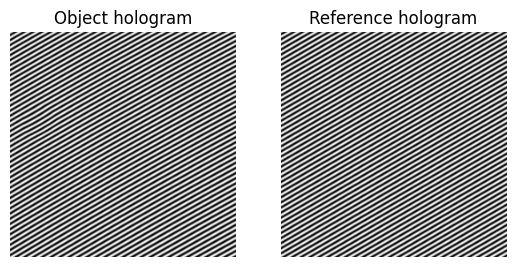

In [30]:
holo = hologram_frame(amp, phase)
ref = hologram_frame(np.ones_like(phase), np.zeros_like(phase))

# Plot
f, ax = plt.subplots(1, 2)
ax[0].imshow(holo, cmap='gray')
ax[0].title.set_text('Object hologram')
ax[0].set_axis_off()
ax[1].imshow(ref, cmap='gray')
ax[1].title.set_text('Reference hologram')
ax[1].set_axis_off()

Compute reconstruction

In [31]:
dataset_holo = MemoryDataSet(data=holo.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)
dataset_ref = MemoryDataSet(data=ref.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)

Text(0.5, 1.0, 'FFT of the reference hologram')

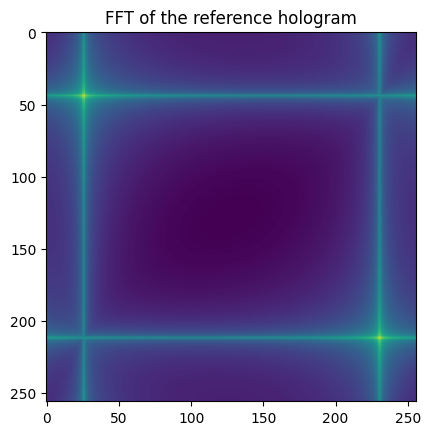

In [32]:
plt.imshow(np.log(np.abs(np.fft.fft2(ref))))
plt.title('FFT of the reference hologram')

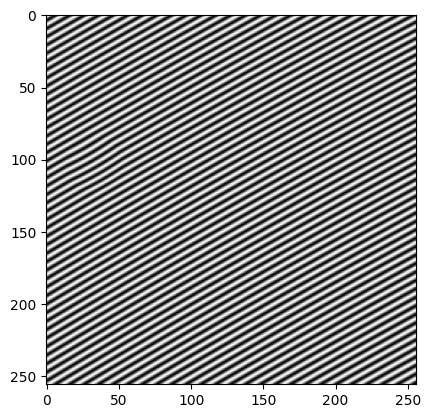

In [33]:
plt.imshow(holo, cmap='gray')

[ 0.          0.00390625  0.0078125   0.01171875  0.015625    0.01953125
  0.0234375   0.02734375  0.03125     0.03515625  0.0390625   0.04296875
  0.046875    0.05078125  0.0546875   0.05859375  0.0625      0.06640625
  0.0703125   0.07421875  0.078125    0.08203125  0.0859375   0.08984375
  0.09375     0.09765625  0.1015625   0.10546875  0.109375    0.11328125
  0.1171875   0.12109375  0.125       0.12890625  0.1328125   0.13671875
  0.140625    0.14453125  0.1484375   0.15234375  0.15625     0.16015625
  0.1640625   0.16796875  0.171875    0.17578125  0.1796875   0.18359375
  0.1875      0.19140625  0.1953125   0.19921875  0.203125    0.20703125
  0.2109375   0.21484375  0.21875     0.22265625  0.2265625   0.23046875
  0.234375    0.23828125  0.2421875   0.24609375  0.25        0.25390625
  0.2578125   0.26171875  0.265625    0.26953125  0.2734375   0.27734375
  0.28125     0.28515625  0.2890625   0.29296875  0.296875    0.30078125
  0.3046875   0.30859375  0.3125      0.31640625  0

Text(0.5, 1.0, 'FFT of the reference hologram')

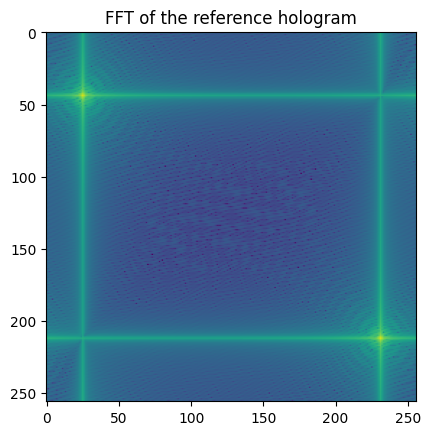

In [34]:
plt.imshow(np.log(np.abs(np.fft.fft2(holo))))
print(np.fft.fftfreq(holo.shape[0]))

plt.title('FFT of the reference hologram')

In [35]:
# Store the hologram in a Singal2D to estimate the sideband position and size
holo_signal2d = hs.signals.Signal2D(ref)
holo_signal2d.set_signal_type("hologram")

sb_position = holo_signal2d.estimate_sideband_position(ap_cb_radius=None, sb='lower')
sb_size = holo_signal2d.estimate_sideband_size(sb_position)

sb_position = sb_position.data
sb_size = sb_size.data[0]

print(sb_position)
print(sb_size)

[44 26]
25.553864678361276


In [36]:
# Define output shape
output_shape = (int(sb_size * 2), int(sb_size * 2))

# Create reconstruction UDF:
holo_udf = HoloReconstructUDF(out_shape=output_shape,
                              sb_position=sb_position,
                              sb_size=sb_size)

# Reconstruct holograms, access data directly
w_holo = ctx.run_udf(dataset=dataset_holo, udf=holo_udf)['wave'].data
w_ref = ctx.run_udf(dataset=dataset_ref, udf=holo_udf)['wave'].data

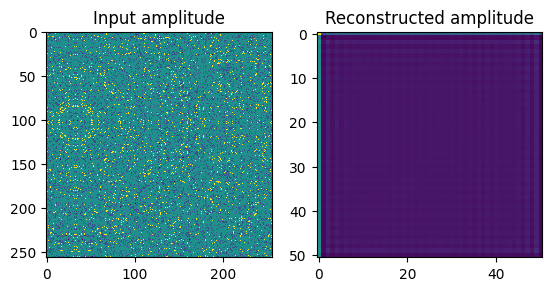

In [37]:
# Correct object wave using reference wave
w = w_holo / w_ref

# Calculate plot phase shift and amplitude
amp_r = np.abs(w)
phase_r = np.angle(w)

# Plot amplitude
f, ax = plt.subplots(1, 2)
ax[0].imshow(amp)
ax[0].title.set_text('Input amplitude')
ax[1].imshow(amp_r[0])
ax[1].title.set_text('Reconstructed amplitude')


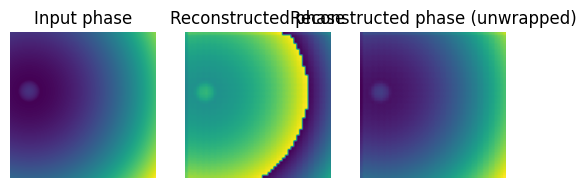

In [40]:
# Unwrap phase:
phase_unwrapped = unwrap_phase(phase_r[0])

# Plot
f, ax = plt.subplots(1, 3)
ax[0].imshow(phase, cmap='viridis')
ax[0].title.set_text('Input phase')
ax[0].set_axis_off()
ax[1].imshow(phase_r[0])
ax[1].title.set_text('Reconstructed phase')
ax[1].set_axis_off()
ax[2].imshow(phase_unwrapped, cmap='viridis')
ax[2].title.set_text('Reconstructed phase (unwrapped)')
ax[2].set_axis_off()

In [39]:
ctx.close()